### Simple RNN model using PyTorch

Welcome to this notebook where we'll be implementing a simple RNN character model with PyTorch to familiarize ourselves with the PyTorch library and get started with RNNs. You can run the code we’re using on FloydHub by clicking the button below and creating the project as well.

In this implementation, we'll be building a model that can complete your sentence based on a few characters or a word used as input.

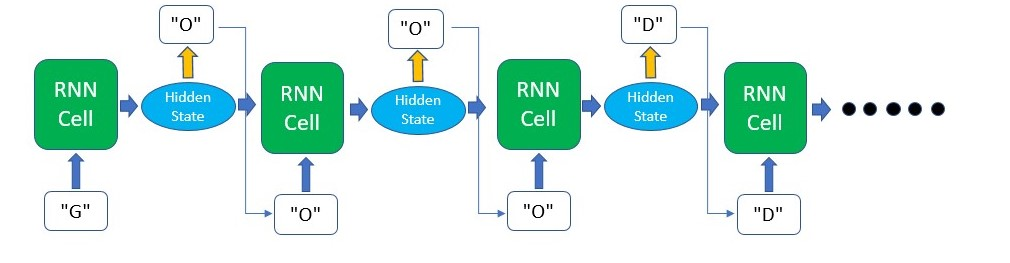

To keep this short and simple, we won't be using any large or external datasets. Instead, we'll just be defining a few sentences to see how the model learns from these sentences. The process that this implementation will take is as follows:

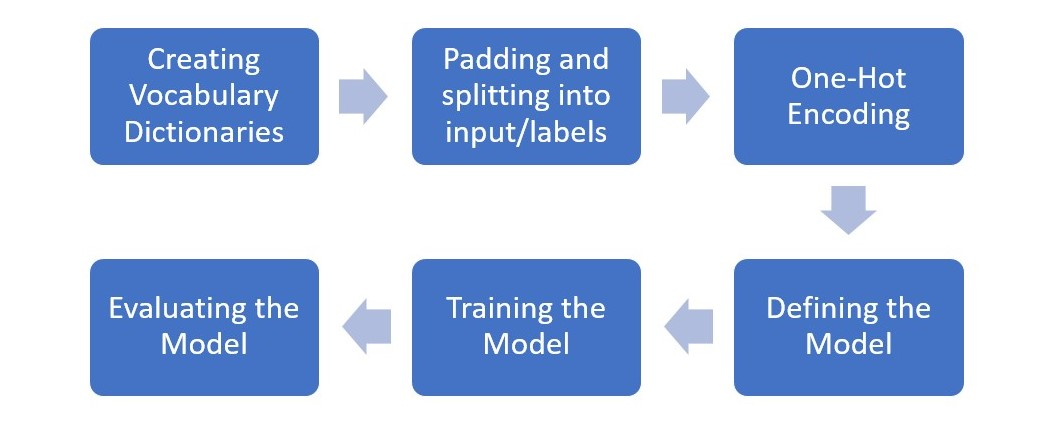

Let's start off by importing the main PyTorch package along with the Variable class used to store our data tensors and the nn package which we will use when building the model. In addition, we'll only be using numpy to pre-process our data as Torch works really well with numpy.

In [1]:
import torch
from torch import nn
import numpy as np

First, we'll define the sentences that we want our model to output when fed with the first word or the first few characters.

Then we'll create a dictionary out of all the characters that we have in the sentences and map them to an integer. This will allow us to convert our input characters to their respective integers (char2int) and vice versa (int2char).

In [2]:
text = ['hey how are you','good i am fine','have a nice day']

# Join all the sentences together and extract the unique characters from the combined sentences
chars = set(''.join(text))

# Creating a dictionary that maps integers to the characters
int2char = dict(enumerate(chars))

# Creating another dictionary that maps characters to integers
char2int = {char: ind for ind, char in int2char.items()}

In [3]:
print(char2int)

{'o': 0, 'u': 1, 'd': 2, 'n': 3, 'c': 4, 'e': 5, 'r': 6, 'm': 7, 'a': 8, 'f': 9, 'g': 10, 'v': 11, 'i': 12, 'h': 13, ' ': 14, 'y': 15, 'w': 16}


Next, we'll be padding our input sentences to ensure that all the sentences are of the sample length. While RNNs are typically able to take in variably sized inputs, we will usually want to feed training data in batches to speed up the training process. In order to used batches to train on our data, we'll need to ensure that each sequence within the input data are of equal size.

Therefore, in most cases, padding can be done by filling up sequences that are too short with 0 values and trimming sequences that are too long. In our case, we'll be finding the length of the longest sequence and padding the rest of the sentences with blank spaces to match that length.

In [4]:
maxlen = len(max(text, key=len))
print("The longest string has {} characters".format(maxlen))

The longest string has 15 characters


In [5]:
# Padding

# A simple loop that loops through the list of sentences and adds a ' ' whitespace until the length of the sentence matches
# the length of the longest sentence
for i in range(len(text)):
    while len(text[i])<maxlen:
        text[i] += ' '

As we're going to predict the next character in the sequence at each time step, we'll have to divide each sentence into

Input data
The last input character should be excluded as it does not need to be fed into the model
Target/Ground Truth Label
One time-step ahead of the Input data as this will be the "correct answer" for the model at each time step corresponding to the input data

In [6]:
# Creating lists that will hold our input and target sequences
input_seq = []
target_seq = []

for i in range(len(text)):
    # Remove last character for input sequence
    input_seq.append(text[i][:-1])
    
    # Remove firsts character for target sequence
    target_seq.append(text[i][1:])
    print("Input Sequence: {}\nTarget Sequence: {}".format(input_seq[i], target_seq[i]))

Input Sequence: hey how are yo
Target Sequence: ey how are you
Input Sequence: good i am fine
Target Sequence: ood i am fine 
Input Sequence: have a nice da
Target Sequence: ave a nice day


Now we can convert our input and target sequences to sequences of integers instead of characters by mapping them using the dictionaries we created above. This will allow us to one-hot-encode our input sequence subsequently.

In [7]:
for i in range(len(text)):
    input_seq[i] = [char2int[character] for character in input_seq[i]]
    target_seq[i] = [char2int[character] for character in target_seq[i]]

Before encoding our input sequence into one-hot vectors, we'll define 3 key variables:

    1. dict_size: The number of unique characters that we have in our text
        This will determine the one-hot vector size as each character will have an assigned index in that vector
    2. seq_len: The length of the sequences that we're feeding into the model
        As we standardised the length of all our sentences to be equal to the longest sentences, this value will be the max             length - 1 as we removed the last character input as well
    3. batch_size: The number of sentences that we defined and are going to feed into the model as a batch

In [8]:
dict_size = len(char2int)
seq_len = maxlen - 1
batch_size = len(text)

def one_hot_encode(sequence, dict_size, seq_len, batch_size):
    # Creating a multi-dimensional array of zeros with the desired output shape
    features = np.zeros((batch_size, seq_len, dict_size), dtype=np.float32)
    
    # Replacing the 0 at the relevant character index with a 1 to represent that character
    for i in range(batch_size):
        for u in range(seq_len):
            features[i, u, sequence[i][u]] = 1
    return features

We also defined a helper function that creates arrays of zeros for each character and replaces the corresponding character index with a **1**.

In [9]:
input_seq = one_hot_encode(input_seq, dict_size, seq_len, batch_size)
print("Input shape: {} --> (Batch Size, Sequence Length, One-Hot Encoding Size)".format(input_seq.shape))

Input shape: (3, 14, 17) --> (Batch Size, Sequence Length, One-Hot Encoding Size)


Since we're done with all the data pre-processing, we can now move the data from numpy arrays to PyTorch's very own data structure - **Torch Tensors**.

In [10]:
input_seq = torch.from_numpy(input_seq)
target_seq = torch.Tensor(target_seq)

Now we've reached the fun part of this project! We'll be defining the model using the Torch library, and this is where you can add or remove layers, be it fully connected layers, convolutational layers, vanilla RNN layers, LSTM layers, and many more! In this post, we'll be using the basic nn.rnn to demonstrate a simple example of how RNNs can be used.

Before we start building the model, let's use a build in feature in PyTorch to check the device we're running on (CPU or GPU). This implementation will not require GPU as the training is really simple. However, as you progress on to large datasets and models with millions of trainable parameters, using the GPU will be very important to speed up your training.

In [11]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


To start building our own neural network model, we can define a class that inherits PyTorch’s base class (nn.module) for all neural network modules. After doing so, we can start defining some variables and also the layers for our model under the constructor. For this model, we’ll only be using 1 layer of RNN followed by a fully connected layer. The fully connected layer will be in-charge of converting the RNN output to our desired output shape.

We’ll also have to define the forward pass function under forward() as a class method. The order the forward function is sequentially executed, therefore we’ll have to pass the inputs and the zero-initialized hidden state through the RNN layer first, before passing the RNN outputs to the fully-connected layer. Note that we are using the layers that we defined in the constructor.

The last method that we have to define is the method that we called earlier to initialize the hidden state - init_hidden(). This basically creates a tensor of zeros in the shape of our hidden states.

### RNN model

In [12]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        # Defining some parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        #Defining the layers
        # RNN Layer
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   
        # Fully connected layer
        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        #Initializing hidden state for first input using method defined below
        hidden = self.init_hidden(batch_size)

        # Passing in the input and hidden state into the model and obtaining outputs
        out, hidden = self.rnn(x, hidden)
        
        # Reshaping the outputs such that it can be fit into the fully connected layer
        out = out.contiguous().view(-1, self.hidden_dim)
        out = self.fc(out)
        
        return out, hidden
    
    def init_hidden(self, batch_size):
        # This method generates the first hidden state of zeros which we'll use in the forward pass
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim).to(device)
         # We'll send the tensor holding the hidden state to the device we specified earlier as well
        return hidden

After defining the model above, we'll have to instantiate the model with the relevant parameters and define our hyperparamters as well. The hyperparameters we're defining below are:

 - n_epochs: Number of Epochs --> This refers to the number of times our model will go through the entire training dataset
 - lr: Learning Rate --> This affects the rate at which our model updates the weights in the cells each time backpropogation is done
    * A smaller learning rate means that the model changes the values of the weight with a smaller magnitude
    * A larger learning rate means that the weights are updated to a larger extent for each time step

Similar to other neural networks, we have to define the optimizer and loss function as well. We’ll be using CrossEntropyLoss as the final output is basically a classification task.

In [13]:
# Instantiate the model with hyperparameters
model = Model(input_size=dict_size, output_size=dict_size, hidden_dim=12, n_layers=1)
# We'll also set the model to the device that we defined earlier (default is CPU)
model = model.to(device)

# Define hyperparameters
n_epochs = 100
lr=0.01

# Define Loss, Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Now we can begin our training! As we only have a few sentences, this training process is very fast. However, as we progress, larger datasets and deeper models mean that the input data is much larger and the number of parameters within the model that we have to compute is much more.

In [14]:
# Training Run
input_seq = input_seq.to(device)
for epoch in range(1, n_epochs + 1):
    optimizer.zero_grad() # Clears existing gradients from previous epoch
    #input_seq = input_seq.to(device)
    output, hidden = model(input_seq)
    output = output.to(device)
    target_seq = target_seq.to(device)
    loss = criterion(output, target_seq.view(-1).long())
    loss.backward() # Does backpropagation and calculates gradients
    optimizer.step() # Updates the weights accordingly
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, n_epochs), end=' ')
        print("Loss: {:.4f}".format(loss.item()))

Epoch: 10/100............. Loss: 2.4484
Epoch: 20/100............. Loss: 2.1693
Epoch: 30/100............. Loss: 1.8133
Epoch: 40/100............. Loss: 1.4415
Epoch: 50/100............. Loss: 1.0641
Epoch: 60/100............. Loss: 0.7562
Epoch: 70/100............. Loss: 0.5247
Epoch: 80/100............. Loss: 0.3557
Epoch: 90/100............. Loss: 0.2457
Epoch: 100/100............. Loss: 0.1786


Let’s test our model now and see what kind of output we will get. Before that, let’s define some helper function to convert our model output back to text.

In [15]:
def predict(model, character):
    # One-hot encoding our input to fit into the model
    character = np.array([[char2int[c] for c in character]])
    character = one_hot_encode(character, dict_size, character.shape[1], 1)
    character = torch.from_numpy(character)
    character = character.to(device)
    
    out, hidden = model(character)

    prob = nn.functional.softmax(out[-1], dim=0).data
    # Taking the class with the highest probability score from the output
    char_ind = torch.max(prob, dim=0)[1].item()

    return int2char[char_ind], hidden

In [16]:
def sample(model, out_len, start='hey'):
    model.eval() # eval mode
    start = start.lower()
    # First off, run through the starting characters
    chars = [ch for ch in start]
    size = out_len - len(chars)
    # Now pass in the previous characters and get a new one
    for ii in range(size):
        char, h = predict(model, chars)
        chars.append(char)

    return ''.join(chars)

In [17]:
sample(model, 15, 'good')

'good i am fine '

As we can see, the model is able to come up with the sentence ‘good i am fine ‘ if we feed it with the words ‘good’, achieving what we intended for it to do!